# Project Naive Bayes Model

_Authors: Joel Quek (SG)_

# Exploratory Data Analysis

## Import Libraries

In [96]:
#All libraries used in this project are listed here
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

import re
from bs4 import BeautifulSoup 

from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score, make_scorer, recall_score, precision_score,accuracy_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score, plot_roc_curve, roc_auc_score, recall_score, precision_score, f1_score


# Open Scraped Datasets

The jupytyer notebooks for scraping are 'reddit-scrape.ipynb' and 'wallstreetbets-scrape.ipynb'

In [97]:
investing_df = pd.read_csv('datasets/investing.csv')
stockmarket_df = pd.read_csv('datasets/stockmarket.csv')

## r/investing

In [98]:
investing_df.shape

(7995, 75)

In [99]:
investing_df.iloc[investing_df.shape[0]-1]['created_utc']

# GMT: Friday, July 8, 2022 9:18:46 AM

1657271926

In [100]:
investing_df=investing_df[['subreddit', 'author', 'selftext', 'title']]
investing_df.head()

,subreddit,author,selftext,title
0,investing,HomeInvading,"Hey guys, I’m a 22 year old male, I grew up wi...",Help a young man out would ya?
1,investing,ocean-airseashell10,[removed],Treasury bonds is it a good idea to buy
2,investing,ocean-airseashell10,[removed],How to buy treasury bonds? Is treasury’s direc...
3,investing,iamjokingiamserious,[removed],Early Exercise of Stock Options
4,investing,jamesterryburke01,Hello Redditors 👋 \n\nI work as a Investment C...,Alternative Investments -


## r/stockmarket

In [101]:
stockmarket_df.shape

(7494, 81)

In [102]:
stockmarket_df.iloc[stockmarket_df.shape[0]-1]['created_utc']

# GMT: Wednesday, July 13, 2022 2:13:58 AM

1657678438

In [103]:
stockmarket_df=stockmarket_df[['subreddit', 'author', 'selftext', 'title']]
stockmarket_df.head()

,subreddit,author,selftext,title
0,StockMarket,zitrored,NaN,Looking for the next exogenous event that take...
1,StockMarket,CompetitiveMission1,[Link to the full article (4 min read)](https:...,China stocks notch trillion-dollar gain on hop...
2,StockMarket,jaltrading21,NaN,Get ready for some economic news and company e...
3,StockMarket,ShabbyShamble,NaN,Market Recap! Bear Market Blues! Palantir (PLT...
4,StockMarket,PriceActionHelp,NaN,Why it's not smart to rely on the RSI divergence


# Final Cleaning 

## Handling Missing Values

In [104]:
investing_df['selftext']=investing_df['selftext'].fillna('')
stockmarket_df['selftext']=stockmarket_df['selftext'].fillna('')


In [105]:
investing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7995 entries, 0 to 7994
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   subreddit  7995 non-null   object
 1   author     7995 non-null   object
 2   selftext   7995 non-null   object
 3   title      7995 non-null   object
dtypes: object(4)
memory usage: 250.0+ KB


In [106]:
stockmarket_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7494 entries, 0 to 7493
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   subreddit  7494 non-null   object
 1   author     7494 non-null   object
 2   selftext   7494 non-null   object
 3   title      7494 non-null   object
dtypes: object(4)
memory usage: 234.3+ KB


## Feature Engineering

I will combine the text from columns 'author','selftext' and 'title'

In [107]:
#investing_df['Posts']='Author: '+investing_df['author']+' Title: ' + investing_df['title']+' Text: '+investing_df['selftext']
#stockmarket_df['Posts']='Author: '+stockmarket_df['author']+' Title: ' + stockmarket_df['title']+' Text: '+stockmarket_df['selftext']


In [108]:
investing_df['Posts']=investing_df['author']+ ' '+investing_df['title']+' '+investing_df['selftext']
stockmarket_df['Posts']=stockmarket_df['author']+ ' '+stockmarket_df['title']+' '+stockmarket_df['selftext']

In [109]:
investing_df=investing_df[['subreddit','Posts']]
stockmarket_df=stockmarket_df[['subreddit','Posts']]


In [110]:
investing_df.head(3)

,subreddit,Posts
0,investing,HomeInvading Help a young man out would ya? He...
1,investing,ocean-airseashell10 Treasury bonds is it a goo...
2,investing,ocean-airseashell10 How to buy treasury bonds?...


In [111]:
stockmarket_df.head(3)

,subreddit,Posts
0,StockMarket,zitrored Looking for the next exogenous event ...
1,StockMarket,CompetitiveMission1 China stocks notch trillio...
2,StockMarket,jaltrading21 Get ready for some economic news ...


## Concatenate both Dataframes

In [112]:
df = pd.concat([investing_df,stockmarket_df],ignore_index=True)

In [113]:
df.shape

(15489, 2)

In [114]:
df['subreddit'].value_counts()

investing      7995
StockMarket    7494
Name: subreddit, dtype: int64

In [115]:
df.head()

,subreddit,Posts
0,investing,HomeInvading Help a young man out would ya? He...
1,investing,ocean-airseashell10 Treasury bonds is it a goo...
2,investing,ocean-airseashell10 How to buy treasury bonds?...
3,investing,iamjokingiamserious Early Exercise of Stock Op...
4,investing,jamesterryburke01 Alternative Investments - He...


## Lowercase

In [116]:
df['Posts']=[c.lower() for c in df['Posts']]

## Remove Non Letters

In [117]:
df['Posts']=df['Posts'].map(lambda x: re.sub("[^a-zA-Z]", " ", x)) 

## Remove Stop Words

In [118]:
def remove_stop_words(text):
    stops = stopwords.words('english')
    stops=set(stops)
    text = " ".join([word for word in text.split() if word not in (stops)])
    # text = [w for w in text if not w in stops]

    return text

In [119]:
df['Posts']=df['Posts'].map(lambda x: remove_stop_words(x))

## Hot Encode Target Vector

In [120]:
df['subreddit']=df['subreddit'].map({'investing': 0, 'StockMarket': 1})

In [121]:
df.head()

,subreddit,Posts
0,0,homeinvading help young man would ya hey guys ...
1,0,ocean airseashell treasury bonds good idea buy...
2,0,ocean airseashell buy treasury bonds treasury ...
3,0,iamjokingiamserious early exercise stock optio...
4,0,jamesterryburke alternative investments hello ...


In [122]:
X=df['Posts']
y=df['subreddit']

In [123]:
y.value_counts(normalize = True)

0    0.516173
1    0.483827
Name: subreddit, dtype: float64

In [124]:
# Split the data into the training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y, # stratify means the proportion of 0s and 1s are kept
                                                    random_state=42)

----

# Count Vectorizer

In [125]:
# Instantiate a CountVectorizer with the default hyperparameters.
cvec = CountVectorizer()

In [126]:
# Fit the vectorizer on our corpus.
cvec.fit(X_train)

CountVectorizer()

In [127]:
# Transform the corpus.
X_train = cvec.transform(X_train) 
# transform creates the vector of words

In [128]:
X_train.shape

(10377, 29062)

In [129]:
print(X_train)

  (0, 492)	1
  (0, 1333)	1
  (0, 5180)	1
  (0, 10765)	1
  (0, 13654)	1
  (0, 14529)	1
  (0, 16149)	1
  (0, 16984)	1
  (0, 25442)	1
  (0, 25662)	1
  (1, 286)	1
  (1, 3116)	1
  (1, 3428)	1
  (1, 12578)	1
  (1, 20803)	1
  (1, 21060)	1
  (2, 358)	1
  (2, 3506)	1
  (2, 3521)	1
  (2, 4505)	1
  (2, 4593)	1
  (2, 6099)	2
  (2, 7480)	1
  (2, 8155)	1
  (2, 8625)	1
  :	:
  (10376, 11061)	1
  (10376, 11282)	1
  (10376, 11283)	1
  (10376, 11787)	1
  (10376, 11897)	2
  (10376, 12933)	1
  (10376, 12953)	3
  (10376, 12968)	1
  (10376, 14538)	1
  (10376, 15784)	1
  (10376, 15999)	1
  (10376, 16307)	1
  (10376, 16868)	1
  (10376, 18821)	1
  (10376, 19351)	1
  (10376, 19365)	1
  (10376, 19585)	1
  (10376, 22157)	1
  (10376, 22451)	1
  (10376, 23042)	1
  (10376, 24014)	1
  (10376, 25441)	1
  (10376, 25507)	1
  (10376, 26096)	1
  (10376, 27092)	1


In [130]:
cvec.get_feature_names()[1000:1010]

c:\Users\redoc\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['amikuna',
 'amilton',
 'amit',
 'aml',
 'amlp',
 'amlzf',
 'ammakshooter',
 'ammo',
 'ammonia',
 'ammonium']

In [131]:
# Transform test
X_test = cvec.transform(X_test) # we fit the CountVectorizer data based on the X_Train and use that model to transform T_Test

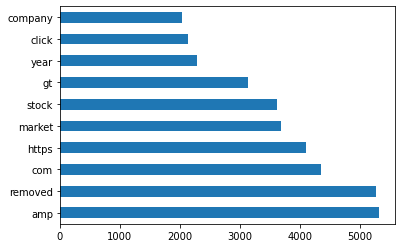

In [132]:
# convert training data to dataframe
X_train_df = pd.DataFrame(X_train.todense(), 
                          columns=cvec.get_feature_names()) # cvec is the CountVectorizer object

# plot top occuring words
X_train_df.sum().sort_values(ascending=False).head(10).plot(kind='barh'); # head(10) gives top ten words

## Baseline Accuracy

In [133]:
y_test.value_counts(normalize=True)

0    0.516236
1    0.483764
Name: subreddit, dtype: float64

# Reinstantiate Train and Test Data

To avoid error of instantiating/fitting count vectorizer down below [IMPORTANT]

In [134]:
# Split the data into the training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y, # stratify means the proportion of 0s and 1s are kept
                                                    random_state=42)

# 1. Naive Bayes with Count Vectorizer

In [135]:
# Let's set a pipeline up with two stages:
# 1. CountVectorizer (transformer)
# 2. Multinomial Naive Bayes (estimator)

pipe3 = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB())
])

In [136]:
cross_val_score(pipe3, X_train, y_train, cv=5)

array([0.74566474, 0.7495183 , 0.75325301, 0.76337349, 0.73204819])

In [137]:
# ii. Fit into model
pipe3.fit(X_train, y_train)

# Training score
print(pipe3.score(X_train, y_train))

# Test score
print(pipe3.score(X_test, y_test))

0.8238411872410137
0.7517605633802817


### Gridsearch

In [138]:
# Search over the following values of hyperparameters:
# Maximum number of features fit: 2000, 3000, 4000, 5000
# Minimum number of documents needed to include token: 2, 3
# Maximum number of documents needed to include token: 90%, 95%
# Check (individual tokens) and also check (individual tokens and 2-grams).

pipe_params = {
    'cvec__max_features': [2_000, 3_000, 4_000, 5_000],
    'cvec__min_df': [2, 3],
    'cvec__max_df': [.9, .95],
    'cvec__ngram_range': [(1,1), (1,2)]
}
# these are for the Grid Search to find the optimum combination of hyperparameters

In [139]:
# Instantiate GridSearchCV.

gs = GridSearchCV(pipe3, # what object are we optimizing?
                  param_grid=pipe_params, # what parameters values are we searching?
                  cv=5) # 5-fold cross-validation.

In [140]:
# Fit GridSearch to training data.
gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('nb', MultinomialNB())]),
             param_grid={'cvec__max_df': [0.9, 0.95],
                         'cvec__max_features': [2000, 3000, 4000, 5000],
                         'cvec__min_df': [2, 3],
                         'cvec__ngram_range': [(1, 1), (1, 2)]})

In [141]:
# What's the best score?
print(gs.best_score_)

0.7219817536040114


In [142]:
# Score model on training set.
gs.score(X_train, y_train)

0.7467476149176062

In [143]:
# Score model on testing set.
gs.score(X_test, y_test)

0.7230046948356808

## Accuracy Check [Naive Bayes with Count Vectorizer]

### Pipeline Accuracy

In [144]:
# Get predictions
preds = pipe3.predict(X_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

c:\Users\redoc\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


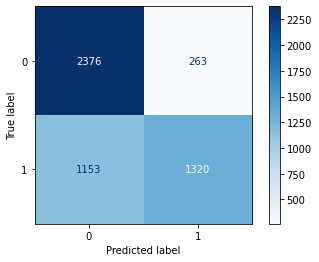

In [145]:
# View confusion matrix

plot_confusion_matrix(gs, X_test, y_test, cmap='Blues', values_format='d');

In [146]:
# Calculate the specificity

spec = tn / (tn + fp)

print('Specificity:', spec)

Specificity: 0.8995831754452445


In [147]:
# Calculate the sensitivity

sens = tp/(tp+fn)

print('Sensitivity:', sens)

Sensitivity: 0.5940153659522847


In [148]:
accuracy = (tp+tn)/(tp+fp+tn+fn)

print('Accuracy:', accuracy)

Accuracy: 0.7517605633802817


---

#### Gridsearch Accuracy

In [149]:
# Get predictions
preds = gs.predict(X_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

In [150]:
cm = confusion_matrix(y_test, preds)
cm

array([[2376,  263],
       [1153, 1320]], dtype=int64)

c:\Users\redoc\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


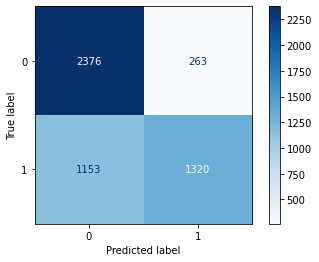

In [181]:
# View confusion matrix

plot_confusion_matrix(gs, X_test, y_test, cmap='Blues', values_format='d');

In [152]:
# Calculate the specificity

spec = tn / (tn + fp)

print('Specificity:', spec)

Specificity: 0.9003410382720728


In [153]:
# Calculate the sensitivity

sens = tp/(tp+fn)

print('Sensitivity:', sens)

Sensitivity: 0.5337646583097453


In [154]:
accuracy = (tp+tn)/(tp+fp+tn+fn)

print('Accuracy:', accuracy)

Accuracy: 0.7230046948356808


## Error Analysis [Type 1 and Type 2 Errors]

https://www.datasciencecentral.com/understanding-type-i-and-type-ii-errors/


### How many Type I errors [FALSE POSITIVE] are there?


In [155]:
fp

263

### How many Type II errors [FALSE NEGATIVE] are there?


In [156]:
fn

1153

### Which error is worse (Type I vs Type II)?


### KIV

---

## ROC Curve

c:\Users\redoc\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


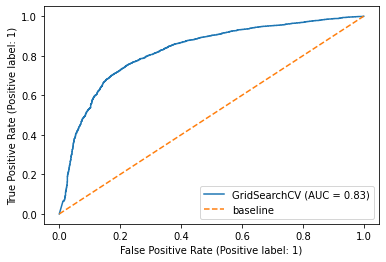

In [157]:
plot_roc_curve(gs, X_test, y_test)
plt.plot([0, 1], [0, 1],
         label='baseline', linestyle='--')
plt.legend();

The area under the ROC curve measures the degree of overlap between the Specificity and Sensitivity distributions. Greater the area, the less overlap.

---

# 2. Naive Bayes with TIFD Vectorizer

In [158]:
# Set up a pipeline with tf-idf vectorizer and multinomial naive bayes

pipe_tvec = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

In [159]:
cross_val_score(pipe_tvec, X_train, y_train, cv=5)

array([0.76734104, 0.77986513, 0.76048193, 0.7739759 , 0.76481928])

In [160]:
# ii. Fit into model
pipe_tvec.fit(X_train, y_train)

# Training score
print(pipe_tvec.score(X_train, y_train))

# Test score
print(pipe_tvec.score(X_test, y_test))

0.8836850727570589
0.7721048513302035


### Gridsearch

In [161]:
# Search over the following values of hyperparameters:
# Maximum number of features fit: 2000, 3000, 4000, 5000
# No stop words and english stop words
# Check (individual tokens) and also check (individual tokens and 2-grams).

pipe_tvec_params = {
    'tvec__max_features': [2_000, 3_000, 4_000, 5_000],
    'tvec__stop_words': [None, 'english'],
    'tvec__ngram_range': [(1,1), (1,2)]
}

In [162]:
# Instantiate GridSearchCV.

gs_tvec = GridSearchCV(pipe_tvec, # what object are we optimizing?
                        param_grid = pipe_tvec_params, # what parameters values are we searching?
                        cv=5) # 5-fold cross-validation.

In [163]:
# Fit GridSearch to training data.
gs_tvec.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('nb', MultinomialNB())]),
             param_grid={'tvec__max_features': [2000, 3000, 4000, 5000],
                         'tvec__ngram_range': [(1, 1), (1, 2)],
                         'tvec__stop_words': [None, 'english']})

In [164]:
print(gs_tvec.best_score_)

0.7530110267660236


In [165]:
# Score model on training set.
gs_tvec.score(X_train, y_train)

0.8033150236099065

In [166]:
# Score model on testing set.
gs_tvec.score(X_test, y_test)

0.7486306729264476

## Accuracy Check [Naive Bayes with TFID Vectorizer]

### Pipeline Accuracy

In [167]:
# Get predictions
preds = pipe_tvec.predict(X_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

c:\Users\redoc\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


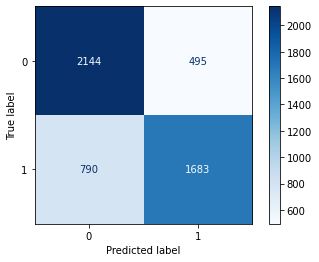

In [168]:
# View confusion matrix

plot_confusion_matrix(gs_tvec, X_test, y_test, cmap='Blues', values_format='d');

In [169]:
# Calculate the specificity

spec = tn / (tn + fp)

print('Specificity:', spec)

Specificity: 0.8624478969306556


In [170]:
# Calculate the sensitivity

sens = tp/(tp+fn)

print('Sensitivity:', sens)

Sensitivity: 0.6756975333602911


In [171]:
accuracy = (tp+tn)/(tp+fp+tn+fn)

print('Accuracy:', accuracy)

Accuracy: 0.7721048513302035


---

#### Gridsearch Accuracy

In [172]:
# Get predictions
preds = gs_tvec.predict(X_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

In [173]:
cm2 = confusion_matrix(y_test, preds)
cm2

array([[2144,  495],
       [ 790, 1683]], dtype=int64)

c:\Users\redoc\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


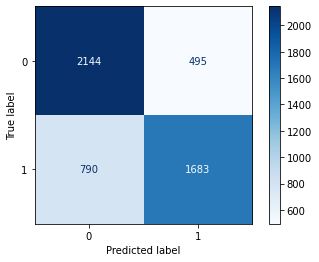

In [174]:
# View confusion matrix

plot_confusion_matrix(gs_tvec, X_test, y_test, cmap='Blues', values_format='d');

In [175]:
# Calculate the specificity

spec = tn / (tn + fp)

print('Specificity:', spec)

Specificity: 0.8124289503599849


In [176]:
# Calculate the sensitivity

sens = tp/(tp+fn)

print('Sensitivity:', sens)

Sensitivity: 0.6805499393449251


In [177]:
accuracy = (tp+tn)/(tp+fp+tn+fn)

print('Accuracy:', accuracy)

Accuracy: 0.7486306729264476


## Error Analysis [Type 1 and Type 2 Errors]

https://www.datasciencecentral.com/understanding-type-i-and-type-ii-errors/


### How many Type I errors [FALSE POSITIVE] are there?


In [178]:
fp

495

### How many Type II errors [FALSE NEGATIVE] are there?


In [179]:
fn

790

### Which error is worse (Type I vs Type II)?


c:\Users\redoc\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


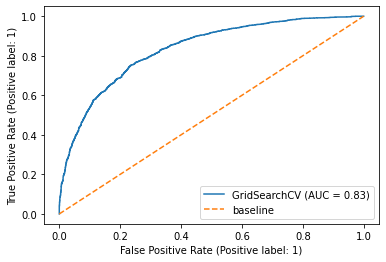

In [180]:
plot_roc_curve(gs_tvec, X_test, y_test)
plt.plot([0, 1], [0, 1],
         label='baseline', linestyle='--')
plt.legend();

The area under the ROC curve measures the degree of overlap between the Specificity and Sensitivity distributions. Greater the area, the less overlap.